Установка библиотеки pycuda

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp310-cp310-linux_x86_64.whl size=660546 sha256=cc117ed691fb8f57355810087d307017739f378923eb6a7a4fa7e4d97965a781
  Stored in directory: /root/.cache/pip/wheels/70/63/40/4bf006182f942d3516b71bb2ff3b57ccbdb8b2c0ee81882b6e
Successfully built pycuda


Импорт нужных библиотек и вывод информации о текущем GPU

In [2]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

import pycuda.autoinit
from pycuda import driver, compiler, gpuarray, tools
tools.make_default_context().get_device().name()

'Tesla T4'

Информация о текущем CPU

In [3]:
!lscpu |grep 'Model name'

Model name:                           Intel(R) Xeon(R) CPU @ 2.00GHz


Написание кода ядра

In [4]:
matmul_kernel = """
    __global__ void MatMulKernel(const float *a, const float *b, float *c, const int size)
    {
        int column = threadIdx.x + blockIdx.x * blockDim.x;
        int row = threadIdx.y + blockIdx.y * blockDim.y;

        float sum = 0;

        for (int i = 0; i < size; i++) {
            sum += a[row * size + i] * b[i * size + column];
        }

        c[row * size + column] = sum;
    }
"""

matmul = compiler.SourceModule(matmul_kernel).get_function("MatMulKernel")

Расчёт времени матричного умножения

In [5]:
mean_times_host_matmul = []     # Массив, содержащий средние времена вычислений на CPU
mean_times_dev_matmul = []      # Массив, содержащий средние времена вычислений на GPU
epsilon = 0.0001                # Необходим для сравнения матриц из дробный чисел
sizes = [128, 256, 512, 1024]    # Рассматриваемые размерности N матриц NxN
count_iteration = 15            # Количество итераций без "холодного старта"

for size in sizes:

  # Создание данных и выделение памяти на CPU
  host_a = np.random.randn(size, size).astype(np.float32)
  host_b = np.random.randn(size, size).astype(np.float32)
  host_c = np.zeros((size, size), dtype=np.float32)
  numpy_c = np.zeros((size, size), dtype=np.float32)

  # Выделение памяти на GPU
  dev_a = driver.mem_alloc(host_a.nbytes)
  dev_b = driver.mem_alloc(host_b.nbytes)
  dev_c = driver.mem_alloc(host_c.nbytes)

  """
  Вычисление размерности блоков и сетки блоков.
  Каждый блок состоит из варпов (32 нити) и содержит макс. 1024 нити
  """
  if size > 32:
    gdim, remains = divmod(size, 32)  # divmod(a, b) return a // b, a % b

    # Двумерный блок из 32 варпов
    bdim = (32, 32, 1)
    # Вычисление размерности сетки блоков
    gdim = (gdim + (remains > 0), gdim + (remains > 0))
  else:
    bdim = (size, size, 1)
    gdim = (1, 1)

  # Массивы с временами на соответствующем устройстве для вычисления среднего
  times_host_matmul = []
  times_dev_matmul = []

  for i in range(count_iteration + 1):
    # Вычисление времени на GPU (с учётом пересылки данных)
    start_time = time()
    driver.memcpy_htod(dev_a, host_a)
    driver.memcpy_htod(dev_b, host_b)
    matmul(dev_a, dev_b, dev_c, np.int32(size), block=bdim, grid=gdim)
    driver.memcpy_dtoh(host_c, dev_c)
    end_time = time()
    times_dev_matmul.append(end_time - start_time)

    # Вычисление времени на CPU
    start_time = time()
    numpy_c = np.dot(host_a, host_b)
    end_time = time()
    times_host_matmul.append(end_time - start_time)

  # Вычтсление среднего значения времени без "холодного старта"
  mean_times_dev_matmul.append(np.mean(times_dev_matmul[1:]))
  mean_times_host_matmul.append(np.mean(times_host_matmul[1:]))

  # Сравнение матриц на CPU и на GPU с допустимой погрешностью в epsilon
  print(f"Size = {size}. numpy_c равен host_c с погрешностью {epsilon}?\t" +
        str(np.allclose(numpy_c, host_c, atol=epsilon)))

print(f"CPU = {mean_times_host_matmul}")
print(f"GPU = {mean_times_dev_matmul}")

Size = 128. numpy_c равен host_c с погрешностью 0.0001?	True
Size = 256. numpy_c равен host_c с погрешностью 0.0001?	True
Size = 512. numpy_c равен host_c с погрешностью 0.0001?	True


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


Size = 1024. numpy_c равен host_c с погрешностью 0.0001?	True
CPU = [6.659825642903645e-05, 0.0003541151682535807, 0.0027498722076416014, 0.018445380528767905]
GPU = [0.00017355283101399738, 0.0004330317179361979, 0.0019585768381754558, 0.010252793629964193]


Сравнение скоростей двух реализаций

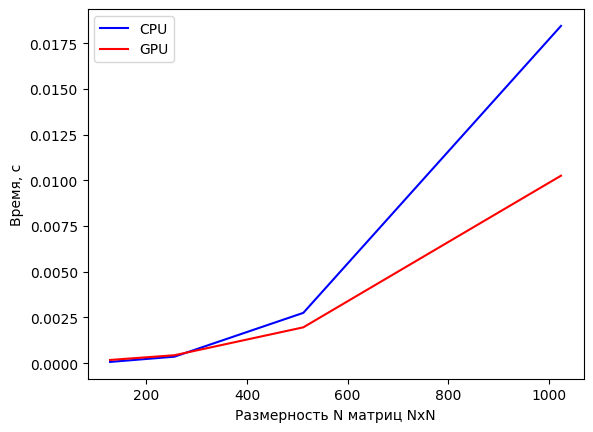

In [6]:
plt.plot(sizes, mean_times_host_matmul, color="blue", label="CPU")
plt.plot(sizes, mean_times_dev_matmul, color="red", label="GPU")
plt.xlabel("Размерность N матриц NxN")
plt.ylabel("Время, с")
plt.legend()

Визуализация ускорения на GPU

Text(0, 0.5, 'Отношение времени на CPU к времени на GPU')

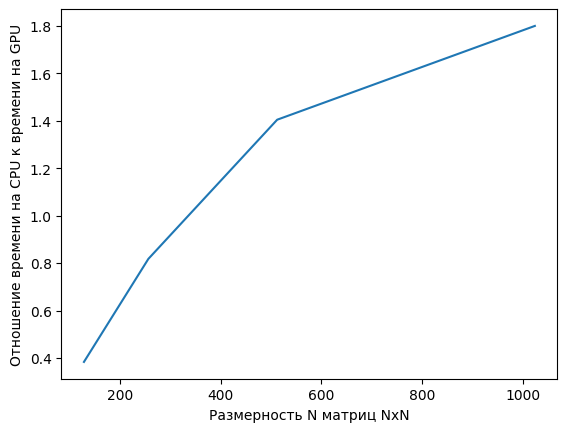

In [7]:
plt.plot(sizes, np.array(mean_times_host_matmul) / np.array(mean_times_dev_matmul))
plt.xlabel("Размерность N матриц NxN")
plt.ylabel("Отношение времени на CPU к времени на GPU")

Сохранение результатов в excel

In [8]:
df = pd.DataFrame({"CPU": mean_times_host_matmul, "GPU": mean_times_dev_matmul}, index=sizes)
df.to_excel("CPU and GPU.xlsx")
df

,CPU,GPU
128,0.000067,0.000174
256,0.000354,0.000433
512,0.002750,0.001959
1024,0.018445,0.010253
